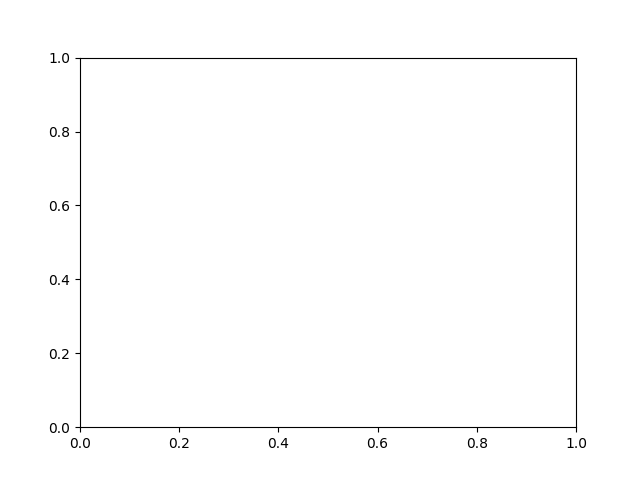

In [1]:
%matplotlib widget
from spacer3d.utils import plot_process, plot_ripley, get_equivalent_color, plot_individuals, plot_combined_univariate, plot_combined_multivariate, plot_combined_platelets
from glob import glob
import os

In [2]:
path = "/home/dkermany/BoneSegmentation/ripley_results/platelets"

In [3]:
# from glob import glob
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# 
# def _calculate_p_values_two_tailed(observed_ripleyK, simulated_ripleyKs):
#     """
#     Calculate two-tailed p-values for Ripley's K function at each radius.
# 
#     Parameters:
#     observed_ripleyK (array-like): An array of Ripley's K values calculated from the observed data for each radius.
#     simulated_ripleyKs (array-like of array-like): A 2D array where each row represents the Ripley's K values 
#                                                     from a single Monte Carlo simulation across the same radii as the observed data.
# 
#     Returns:
#     np.array: An array of two-tailed p-values for each radius.
#     """
#     # Initialize an array to hold p-values for each radius
#     p_values = np.zeros_like(observed_ripleyK, dtype=float)
# 
#     # Calculate p-value for each radius
#     for i in range(len(observed_ripleyK)):
#         # Count how many simulated Ripley's K values are more extreme than the observed value
#         # For a two-tailed test, consider both tails
#         # print((i, simulated_ripleyKs[:, i], observed_ripleyK[i]))
#         lower_extreme_count = np.sum(simulated_ripleyKs[:, i] < observed_ripleyK[i])
#         upper_extreme_count = np.sum(simulated_ripleyKs[:, i] >= observed_ripleyK[i])
#         
#         # For two-tailed, the extremeness is considered from both ends; thus, take the minimum count
#         # and multiply by 2 to account for both tails
#         extreme_count = min(lower_extreme_count, upper_extreme_count) * 2
#         
#         # Ensure the p-value does not exceed 1
#         p_values[i] = np.minimum(extreme_count / simulated_ripleyKs.shape[0], 1.0)
# 
#     return p_values
# 
# def plot_p_values(rstats_path, save=False, output_folder="./ripley_results/"):
#     palette = sns.color_palette("rocket_r")
#     def get_rstats_files(path):
#         return glob(f"{path}/*.csv")
# 
#     def _plot(p_values_array, radii):
#         # p_values_df = pd.DataFrame({
#         #     "P-Value": np.concatenate(p_values_array),  # Flatten the list of arrays into one long array
#         #     "Set": np.repeat(np.arange(1, len(p_values_array)+1), len(p_values_array[0])),
#         #     "Radius": np.tile(radii, len(p_values_array)),
#         # })
#         p_values_long_list = []
#         for i, p_values in enumerate(p_values_array, start=1):
#             for radius, p_value in zip(radii, p_values):
#                 p_values_long_list.append({
#                     "Radius": radius,
#                     "P-Value": p_value,
#                     "Set": f"Sample {i}"  # Label each set for identification
#                 })
#         p_values_df = pd.DataFrame(p_values_long_list)
# 
#         plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
# 
#         # Plot using seaborn
#         sns.lineplot(data=p_values_df, x='Radius', y='P-Value', hue="Set", style="Set", linestyle='-', zorder=3, alpha=0.3, legend="brief")
# 
#         # Draw a dotted horizontal line for the 0.05 threshold
#         color = palette[4]
#         plt.hlines(y=0.05, xmin=np.min(radii), xmax=np.max(radii), color=get_equivalent_color(color, 0.4), label='p<0.05 Threshold', linewidth=1)
#         plt.fill_between(radii, 0, 0.05, color=get_equivalent_color(color, 0.1))
# 
#         # Flip the y-axis
#         plt.gca().invert_yaxis()
# 
#         # Add labels and title for clarity
#         plt.xlabel('Radius')
#         plt.ylabel('P-Value')
#         plt.legend()
#         plt.show()
#         
#     
# 
#     rstats_files = get_rstats_files(rstats_path)
#     print("Loaded:", rstats_files)
# 
#     # filter our monte carlo results
#     rstats_files = [os.path.splitext(os.path.basename(f))[0] for f in rstats_files if "random" not in f]
#     u_rstats_files = sorted([f for f in rstats_files if "univariate" in f])
#     m_rstats_files = sorted([f for f in rstats_files if "multivariate" in f])
# 
#     types = ["tumor", "ng2", "branch", "tvc"]
#     for t in types[:1]:
#         t_files = [i for i in u_rstats_files if t in i]
# 
#         p_values_array = []
#         for i, filename in enumerate(t_files):
#             # Construct the path for the CSV file
#             fullpath = os.path.join(rstats_path, f"{filename}.csv")
#             prefix, _, date, id, mode, label, _ = filename.split("_")
#             
#             # Construct the path for the random CSV file
#             rand_fullpath = os.path.join(rstats_path, f"FV10__{date}_{id}_random_{mode}_{label}_rstats.csv")
#     
#             # Load the CSV file and random CSV file into DataFrames
#             rstats = pd.read_csv(fullpath)
#             rand_rstats = pd.read_csv(rand_fullpath)
# 
#             # plot_ripley(rstats, rand_rstats)
# 
#             observed_ripleyK = rstats["K(r)"].to_numpy()
# 
#             # Determine the range of radii
#             min_radius, max_radius = rstats["Radius (r)"].min(), rstats["Radius (r)"].max()
#             expected_length = max_radius - min_radius + 1  # Adjust based on your radius range
# 
#             # Group by 'Line' and extract 'K(r)' values
#             groups = rand_rstats.groupby('Line')['K(r)']
# 
#             simulated_arrays = []
#             for name, group in groups:
#                 # Ensure the group has the expected length; you might need to handle cases where it doesn't
#                 assert len(group) == expected_length
#                 simulated_arrays.append(group.values)
#             simulated_ripleyKs = np.array(simulated_arrays)
# 
#             p_values = _calculate_p_values_two_tailed(observed_ripleyK, simulated_ripleyKs)
#             p_values_array.append(p_values)
#         _plot(p_values_array, np.arange(min_radius, max_radius+1))
#         break
#             

In [4]:
# plot_p_values(path, save=False, output_folder="./ripley_results/")

In [5]:
# Currently only supports univariate plots, will ignore multivariate rstats csv files
# plot_process(path, save=False, output_folder="./ripley_results/")

In [6]:
# Warning: This will work for BoneMets data currently, but it is not yet made for outside datasets
# Currently only supports univariate plots, will ignore multivariate rstats csv files
# plot_individuals(path, save=False, output_folder="./ripley_results/")

In [7]:
# Warning: This will work for BoneMets data currently, but it is not yet generalized for outside datasets
# plot_combined_univariate(path)

In [8]:
# Warning: This will work for BoneMets data currently, but it is not yet generalized for outside datasets
# plot_combined_multivariate(path)

['VAK_21-39-2_48393_5_Obtained_12292021_pred_121_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_161_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_169_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_177_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_209_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_241_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_273_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_305_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_40_univariate_control_rstats', 'VAK_21-39-2_48393_5_Obtained_12292021_pred_80_univariate_control_rstats', 'VAK_21-39-5_48393_5_Obtained_02162022_pred_1011_univariate_control_rstats', 'VAK_21-39-5_48393_5_Obtained_02162022_pred_1043_univariate_control_rstats', 'VAK_21-39-5_48393_5_Obtained_02162022_pred_1075_univariate_control_rstats', 'VAK_21-39

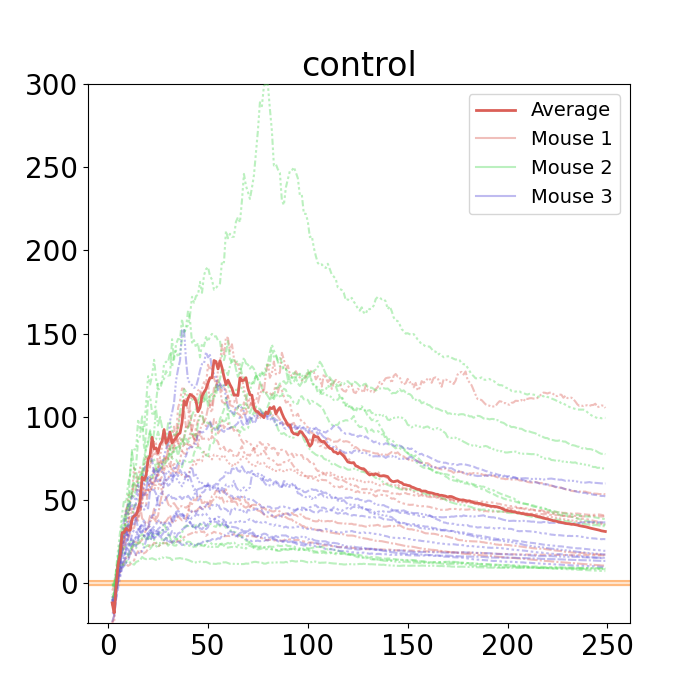

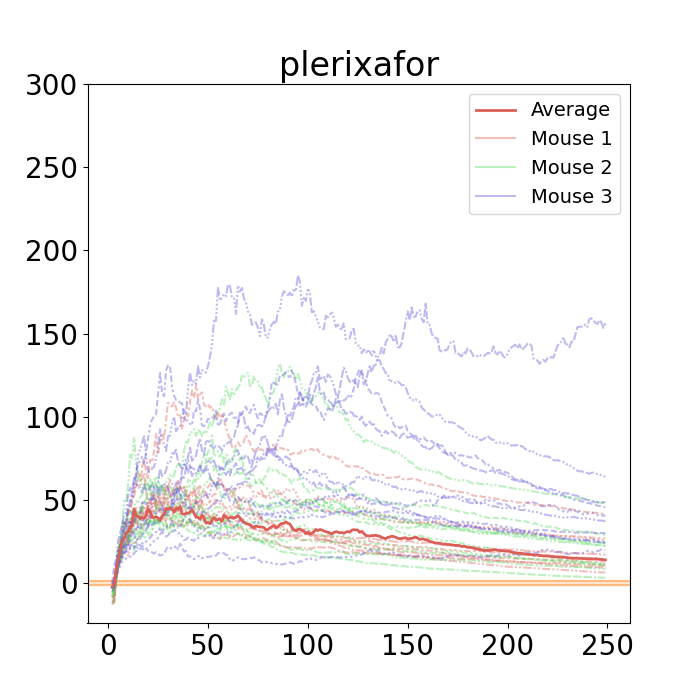

In [9]:
plot_combined_platelets(path)

In [10]:
!pwd

/home/dkermany
